In [12]:
import numpy as np
import matplotlib.pyplot as plt

#from scipy.signal import find_peaks, butter, filtfilt, resample, savgol_filter

In [13]:
# Data Loading
ecg1, ppg1 = np.load('data/first_ecg.npy'), np.load('data/first_ppg.npy')
ecg2, ppg2 = np.load('data/second_ecg.npy'), np.load('data/second_ppg.npy')
ecg3, ppg3 = np.load('data/third_ecg.npy'), np.load('data/third_ppg.npy')

### Task 1: Sampling frequencies detection

The normal resting heart rate is known to be in range 60 to 100 bits per minute (bpm). We will use this range to estimate the sample frequencies.

But firstly, let's visualize the data

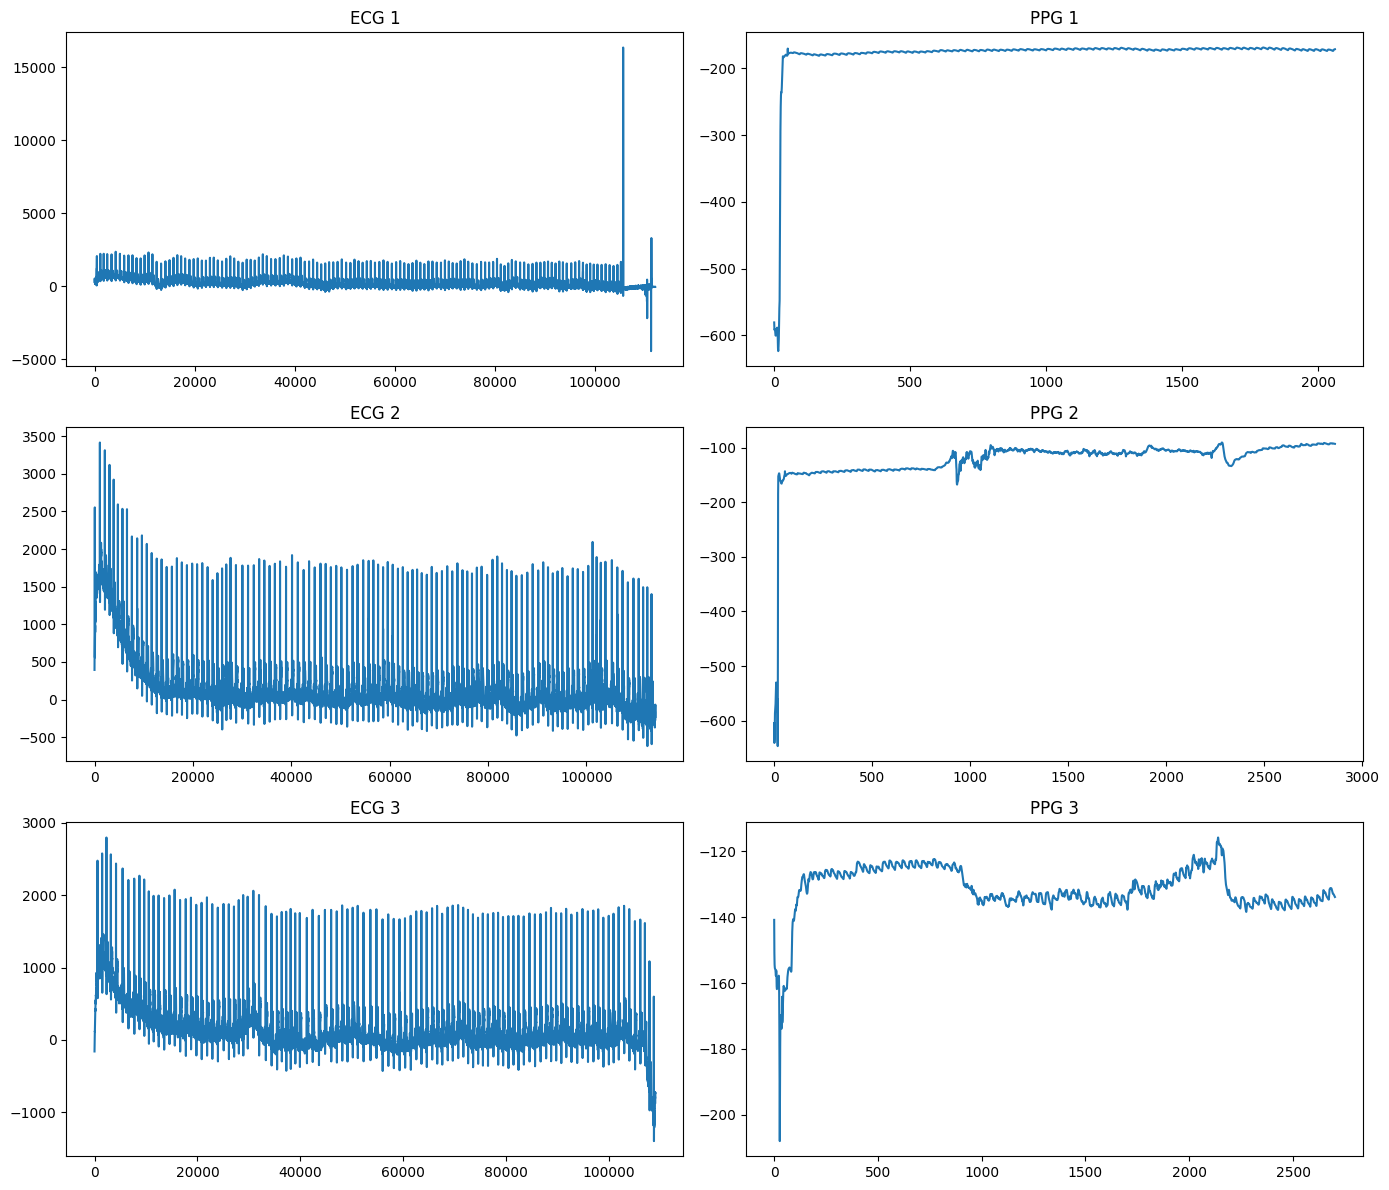

In [14]:
# Create the plots
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

# Plot ECG and PPG for the first dataset
axs[0, 0].plot(ecg1)
axs[0, 0].set_title('ECG 1')
axs[0, 1].plot(ppg1)
axs[0, 1].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1, 0].plot(ecg2)
axs[1, 0].set_title('ECG 2')
axs[1, 1].plot(ppg2)
axs[1, 1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2, 0].plot(ecg3)
axs[2, 0].set_title('ECG 3')
axs[2, 1].plot(ppg3)
axs[2, 1].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

To estimate the sampling frequency we will use the following relation:

$$F_s = \frac{N}{T}$$

where $N$ is a distance between two peaks and $T = X \; bps$ is a typical time between the peaks.

For the whole dataset, we will use 

$$\hat{F_s} = \frac{\sum \limits_{all \; consecutive \; peak \; pairs}N}{n*Xbps}$$
where $n$ is a number of peaks in the dataset.

ECG: R peaks and RR intervals

PPG: Systolic peaks and intervals between them.

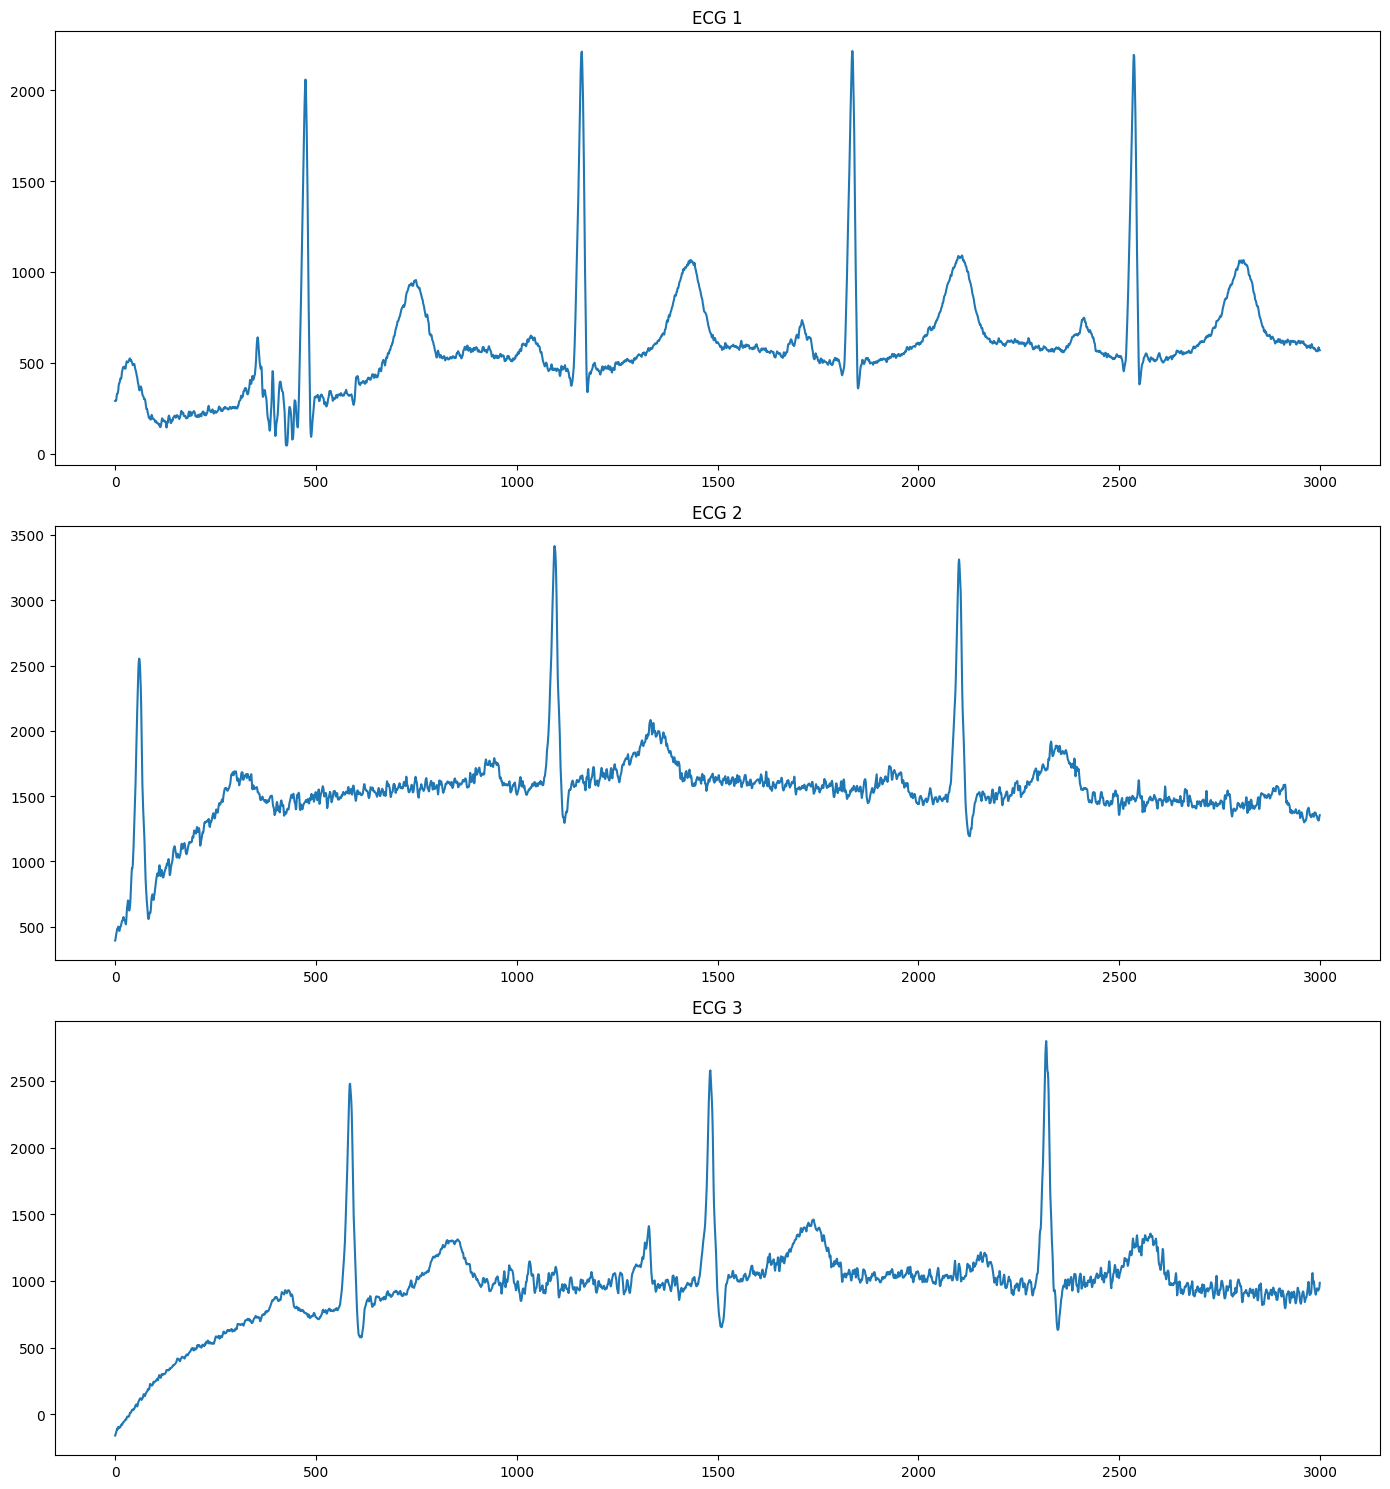

In [15]:
# Looking deeply at the data -- let's see the ECG peaks

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ecg1[:3000])
axs[0].set_title('ECG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ecg2[:3000])
axs[1].set_title('ECG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ecg3[:3000])
axs[2].set_title('ECG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

Looking at three ECG plots, we may assume that typical RR-interval for ECG1 is $\sim 700$ samples, for ECG2 is $\sim 1000$ samples and $\sim 900$ for ECG3

In [16]:
from src.preprocessing import preprocess_signal, remove_dc_offset, lowpass_filter
from src.analysis import detect_sampling_freq, puls_loc, detect_outliers_stft

In [17]:
ecg1_sf = detect_sampling_freq(ecg1, 1, 700)
print(f'The first ECG sampling frequency is ~{ecg1_sf} Hz')

ecg2_sf = detect_sampling_freq(ecg1, 1, 1000)
print(f'The Second ECG sampling frequency is ~{ecg2_sf} Hz')

ecg3_sf = detect_sampling_freq(ecg1, 1, 900)
print(f'The third ECG sampling frequency is ~{ecg3_sf} Hz')

The first ECG sampling frequency is ~807.927536231884 Hz
The Second ECG sampling frequency is ~1419.8846153846155 Hz
The third ECG sampling frequency is ~1419.8846153846155 Hz


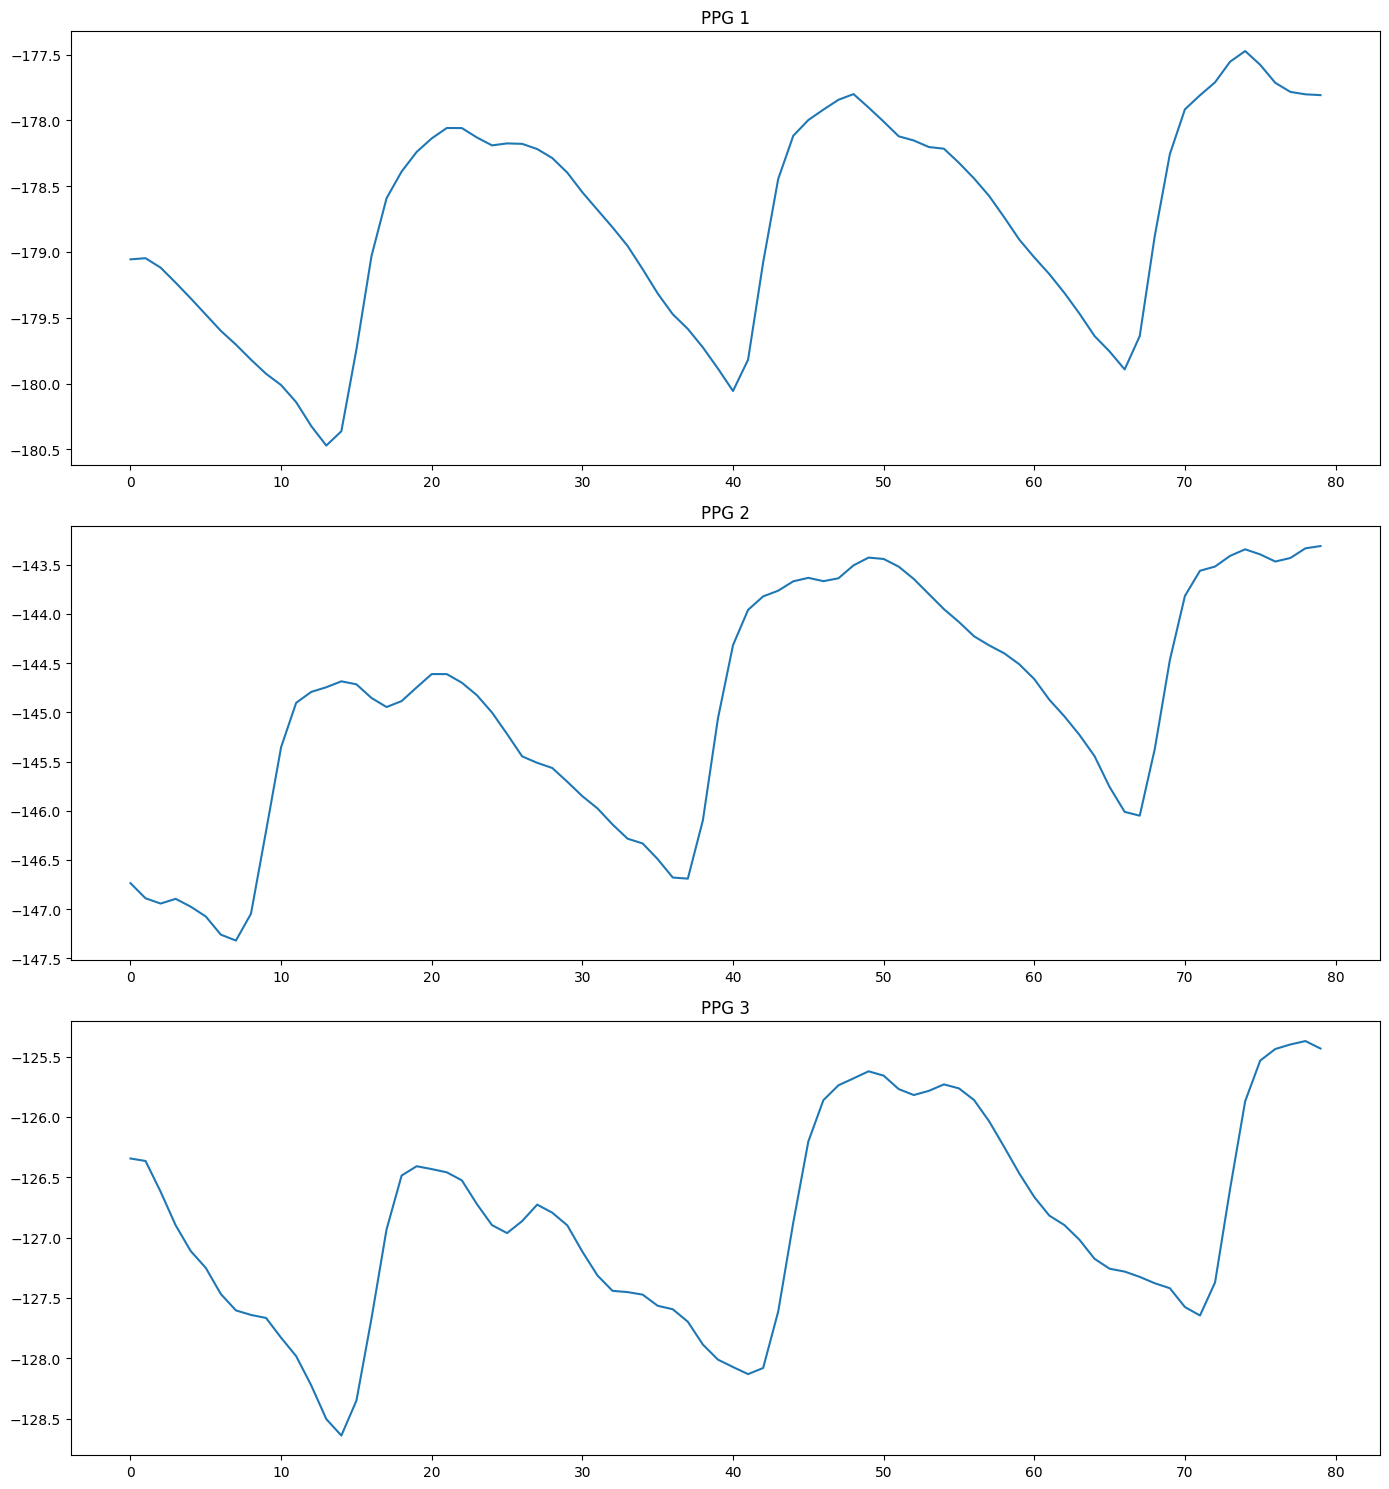

In [18]:
# PPG 

fig, axs = plt.subplots(3, 1, figsize=(14, 15))

# Plot ECG and PPG for the first dataset
axs[0].plot(ppg1[200:280])
axs[0].set_title('PPG 1')

# Plot ECG and PPG for the second dataset
axs[1].plot(ppg2[200:280])
axs[1].set_title('PPG 2')

# Plot ECG and PPG for the third dataset
axs[2].plot(ppg3[200:280])
axs[2].set_title('PPG 3')

# Adjust layout for better readability
plt.tight_layout()
plt.show()

For all PPGs the distance is $\sim 30$ samples

In [19]:
ppg1_sf = detect_sampling_freq(ppg1, bps=1, distance=30)
print(f'The first ECG sampling frequency is ~{ppg1_sf} Hz')

ppg2_sf = detect_sampling_freq(ppg2, 1, 30)
print(f'The Second ECG sampling frequency is ~{ppg2_sf} Hz')

ppg3_sf = detect_sampling_freq(ppg3, 1, 30)
print(f'The third ECG sampling frequency is ~{ppg3_sf} Hz')

The first ECG sampling frequency is ~50.7 Hz
The Second ECG sampling frequency is ~38.54794520547945 Hz
The third ECG sampling frequency is ~38.142857142857146 Hz


### Task 2: Preprocess the signals to remove high frequency noise, offset and trend.

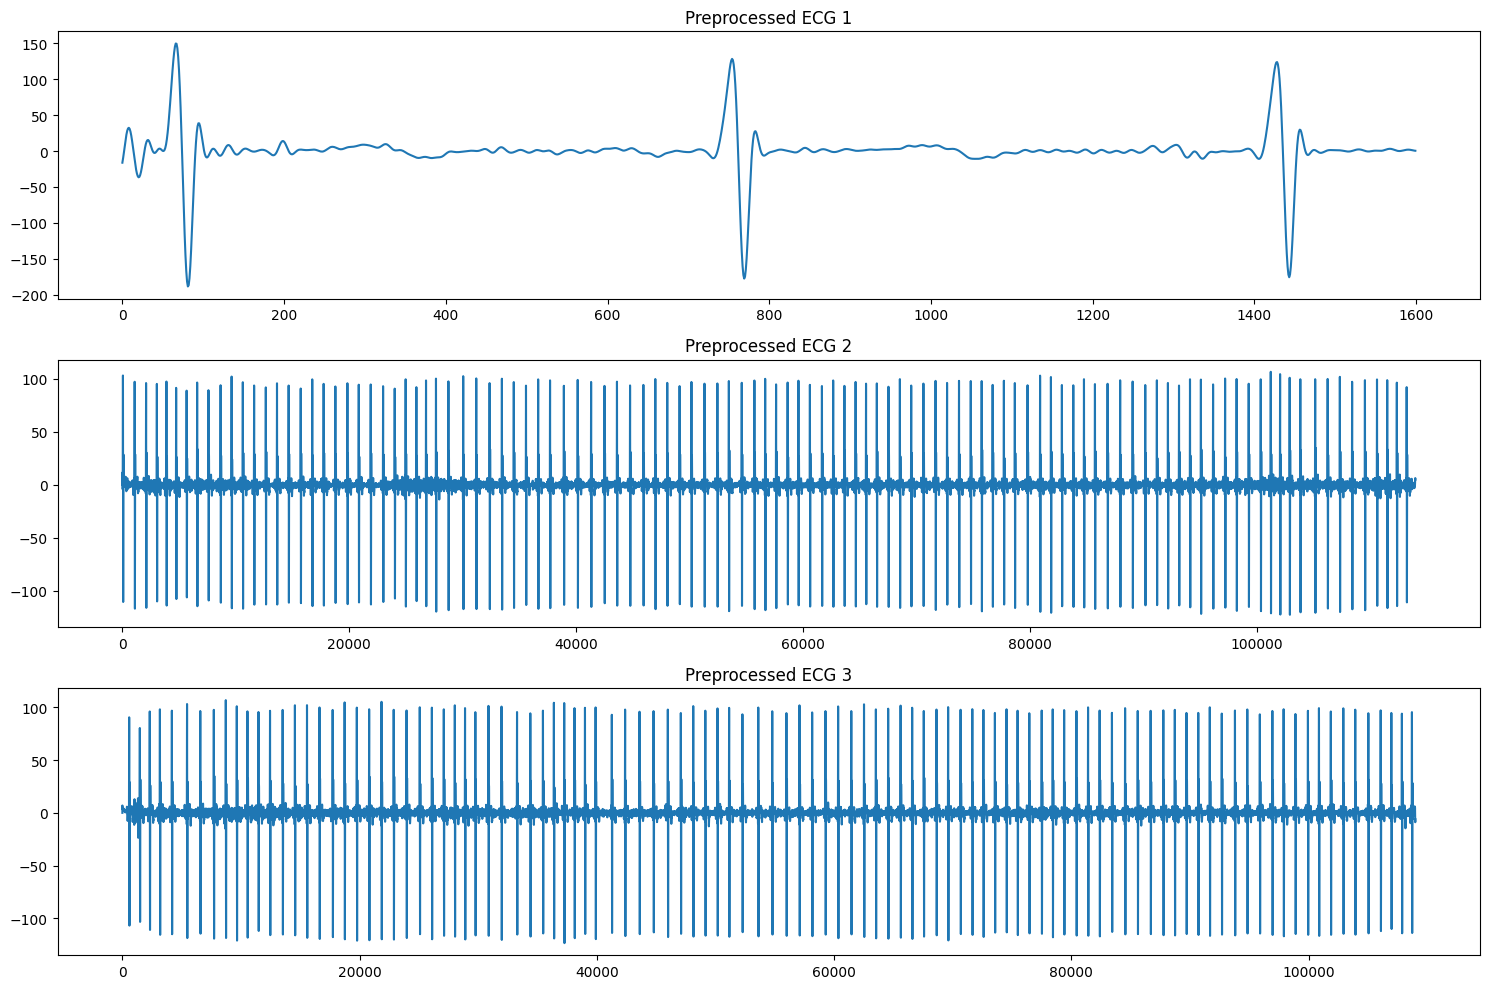

In [20]:
# Filter parameter -- usually 40-50 Hz
ecg_cutoff = 45

# Signal Preprocessing
ecg1_preprocessed = preprocess_signal(ecg1, ecg1_sf, ecg_cutoff)
ecg2_preprocessed = preprocess_signal(ecg2, ecg2_sf, ecg_cutoff)
ecg3_preprocessed = preprocess_signal(ecg3, ecg3_sf, ecg_cutoff)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ecg1_preprocessed[400:2000])
plt.title('Preprocessed ECG 1')

plt.subplot(3, 1, 2)
plt.plot(ecg2_preprocessed)
plt.title('Preprocessed ECG 2')

plt.subplot(3, 1, 3)
plt.plot(ecg3_preprocessed)
plt.title('Preprocessed ECG 3')

plt.tight_layout()
plt.show()

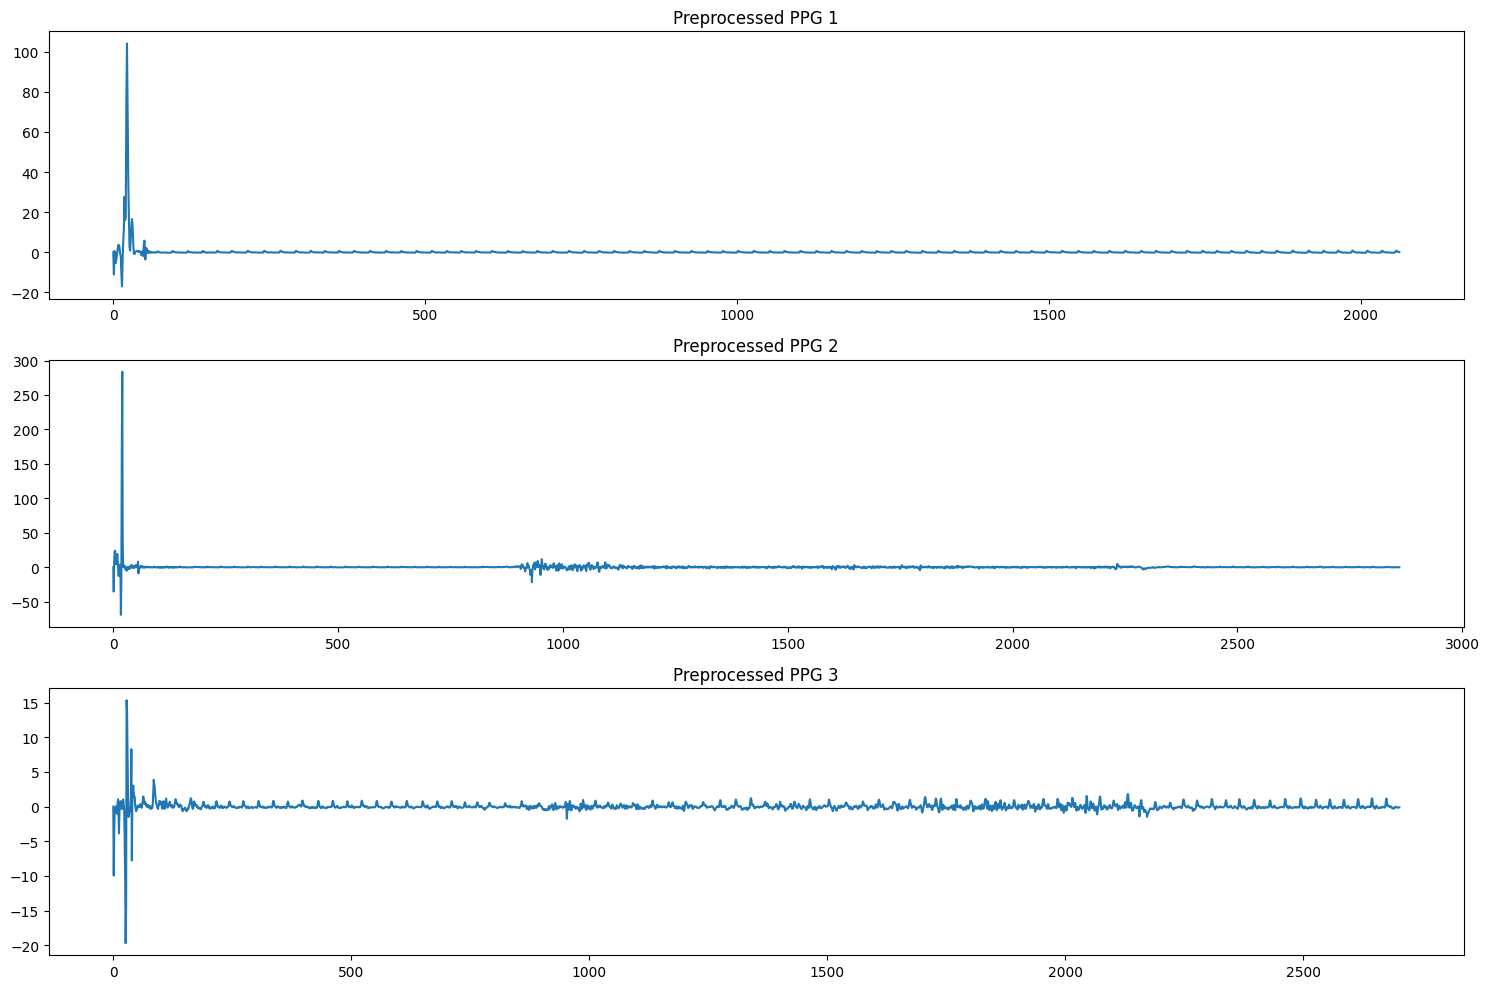

In [21]:
# High-frequency noise in PPGs is usually close to 20 Hz
ppg_cutoff = 19

# Signal Preprocessing
ppg1_preprocessed = preprocess_signal(ppg1, ppg1_sf, ppg_cutoff)
ppg2_preprocessed = preprocess_signal(ppg2, ppg2_sf, ppg_cutoff)
ppg3_preprocessed = preprocess_signal(ppg3, ppg3_sf, ppg_cutoff)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.title('Preprocessed PPG 1')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.title('Preprocessed PPG 2')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.title('Preprocessed PPG 3')

plt.tight_layout()
plt.show()

### Task 3: Puls location

In [22]:
# Peaks detection
ecg1_peaks = puls_loc(ecg1_preprocessed, distance=700)
ecg2_peaks = puls_loc(ecg2_preprocessed, distance=1000)
ecg3_peaks = puls_loc(ecg3_preprocessed, distance=900)

ppg1_peaks = puls_loc(ppg1_preprocessed, distance=ppg1_sf/2)
ppg2_peaks = puls_loc(ppg2_preprocessed, distance=ppg2_sf/2)
ppg3_peaks = puls_loc(ppg3_preprocessed, distance=ppg3_sf/2)

TypeError: find_peaks() got an unexpected keyword argument 'data'

In [ ]:
# ECG Peaks Vizualized

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ecg1_preprocessed, label='Preprocessed ECG 1')
plt.plot(ecg1_peaks, ecg1_preprocessed[ecg1_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 1 with Peaks')
plt.legend()

plt.subplot(3, 1, 2)
plt.plot(ecg2_preprocessed, label='Preprocessed ECG 2')
plt.plot(ecg2_peaks, ecg2_preprocessed[ecg2_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 2 with Peaks')
plt.legend()

plt.subplot(3, 1, 3)
plt.plot(ecg3_preprocessed, label='Preprocessed ECG 3')
plt.plot(ecg3_peaks, ecg3_preprocessed[ecg3_peaks], "x", label='Peaks')
plt.title('Preprocessed ECG 3 with Peaks')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# PPG Peaks Vizualized

plt.figure(figsize=(15, 10))
plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.plot(ppg1_peaks, ppg1_preprocessed[ppg1_peaks], "x")
plt.title('Preprocessed PPG 1 with Peaks')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.plot(ppg2_peaks, ppg2_preprocessed[ppg2_peaks], "x")
plt.title('Preprocessed PPG 2 with Peaks')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.plot(ppg3_peaks, ppg3_preprocessed[ppg3_peaks], "x")
plt.title('Preprocessed PPG 3 with Peaks')

plt.tight_layout()
plt.show()

### Task 4: Anomalies and outliers detection

In [ ]:
ppg1_outliers = detect_outliers_stft(signal=ppg1_preprocessed, fs=ppg1_sf)
ppg2_outliers = detect_outliers_stft(ppg2_preprocessed, ppg2_sf)
ppg3_outliers = detect_outliers_stft(ppg3_preprocessed, ppg3_sf)


# Peaks detected
plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
plt.plot(ppg1_preprocessed)
plt.plot(ppg1_outliers, ppg1_preprocessed[ppg1_outliers], "x")
plt.title('PPG 1 Outliers')

plt.subplot(3, 1, 2)
plt.plot(ppg2_preprocessed)
plt.plot(ppg2_outliers, ppg2_preprocessed[ppg2_outliers], "x")
plt.title('PPG 2 Outliers')

plt.subplot(3, 1, 3)
plt.plot(ppg3_preprocessed)
plt.plot(ppg3_outliers, ppg3_preprocessed[ppg3_outliers], "x")
plt.title('PPG 3 Outliers')

plt.tight_layout()
plt.show()

### Task 5: Sygnals synchronization

In [ ]:
from src.synchronization import synchronize_signals

In [ ]:
ecg1_resampled, ppg1_sync, sf1 = synchronize_signals(
    ecg1_preprocessed,
    ppg1_preprocessed,
    ecg1_sf,
    ppg1_sf)


ecg2_resampled, ppg2_sync, sf2 = synchronize_signals(
    ecg2_preprocessed,
    ppg2_preprocessed,
    ecg2_sf,
    ppg2_sf)

ecg3_resampled, ppg3_sync, sf3 = synchronize_signals(
    ecg3_preprocessed,
    ppg3_preprocessed,
    ecg3_sf,
    ppg3_sf)


# Plot the synchronized signals for verification
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(np.arange(len(ecg1_resampled)) / sf1, ecg1_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg1_sync)) / sf1, ppg1_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 1')

plt.subplot(3, 1, 2)
plt.plot(np.arange(len(ecg2_resampled)) / sf2, ecg2_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg2_sync)) / sf2, ppg2_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 2')

plt.subplot(3, 1, 3)
plt.plot(np.arange(len(ecg3_resampled)) / sf3, ecg3_resampled, label='Resampled ECG')
plt.plot(np.arange(len(ppg3_sync)) / sf3, ppg3_sync, label='PPG')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Synchronized ECG and PPG signals - Set 3')

plt.tight_layout()
plt.show()

### Task 6: PPG evaluation

To evaluate the PPG signals we will use the Signal-to-Noise-Ratio (SNR):

$$SNR = 10 \cdot \log_{10} \frac{Power \; of \; Signal}{Power \; of \; Noise}$$

The larger SNR the better.

Let's start!

In [ ]:
from src.evaluation import calculate_snr, extract_noise

In [ ]:
noise_ppg1 = extract_noise(ppg1)
noise_ppg2 = extract_noise(ppg2)
noise_ppg3 = extract_noise(ppg3)

# Calculate SNR for each PPG signal
snr_ppg1 = calculate_snr(ppg1, noise_ppg1)
snr_ppg2 = calculate_snr(ppg2, noise_ppg2)
snr_ppg3 = calculate_snr(ppg3, noise_ppg3)

# Order the signals from best to worst based on SNR
snr_values = [snr_ppg1, snr_ppg2, snr_ppg3]
ordered_indices = np.argsort(snr_values)[::-1]  # Descending order

# Output the results
print("SNR values (dB):", snr_values)
print("Order of signals from best to worst:", ordered_indices + 1)  # +1 to match signal number

# Plotting for verification (optional)
plt.figure(figsize=(12, 12))

plt.subplot(3, 1, 1)
plt.plot(ppg1, label=f'PPG 1 (SNR: {snr_ppg1:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 1')

plt.subplot(3, 1, 2)
plt.plot(ppg2, label=f'PPG 2 (SNR: {snr_ppg2:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 2')

plt.subplot(3, 1, 3)
plt.plot(ppg3, label=f'PPG 3 (SNR: {snr_ppg3:.2f} dB)')
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Amplitude')
plt.title('PPG Signal 3')

plt.tight_layout()
plt.show()